# 3. Đặt câu hỏi và phân tích dữ liệu để trả lời câu hỏi

Import thư viện cần thiết

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

Tải dữ liệu đã tiền xử lý

In [2]:
df = pd.read_csv("../data/processed/vgchartz_cleaned.csv")

## Câu hỏi 1: Sự phối hợp giữa Publisher và Developer có ảnh hưởng đến hiệu quả game không?


### Motivation & Benefits
Trong ngành game, developer làm ra game, publisher quảng bá và phân phối.<br>
Mối quan hệ giữa hai bên có thể quyết định chất lượng sản phẩm và hiệu quả thương mại.


### Preprocessing
Vì câu hỏi này cần các cặp publisher x developer nên sẽ chỉ lấy những game có đủ cả 2, còn lại nếu trống hoặc unknown thì sẽ bị loại bỏ.
### Analysis
Hiệu quả game được đánh giá thông qua các khía cạnh sau: <br>
(a) Điểm đánh giá từ giới phê bình (critic score)<br>
(b) Điểm đánh giá từ người chơi (user score)<br>
(c) Doanh số trung bình (global sales / shipped / total)<br>
(d) Tần suất hợp tác (số lượng game của mỗi cặp) <br>



In [3]:
invalid = ['unknown', 'Unknown', 'UNKNOWN', 
           'N/A', 'n/a', '-', '--', 'None', 'none', 'TBD', '']

df_clean = df.copy()

# Chuẩn hoá về string
df_clean['publisher'] = df_clean['publisher'].astype(str).str.strip()
df_clean['developer'] = df_clean['developer'].astype(str).str.strip()

# Loại bỏ các dòng có publisher/dev nằm trong list invalid
df_clean = df_clean[
    (~df_clean['publisher'].isin(invalid)) &
    (~df_clean['developer'].isin(invalid))
]


Có phải là publisher và developer đã hợp tác với nhau nhiều thì sẽ có rating cao hơn không?

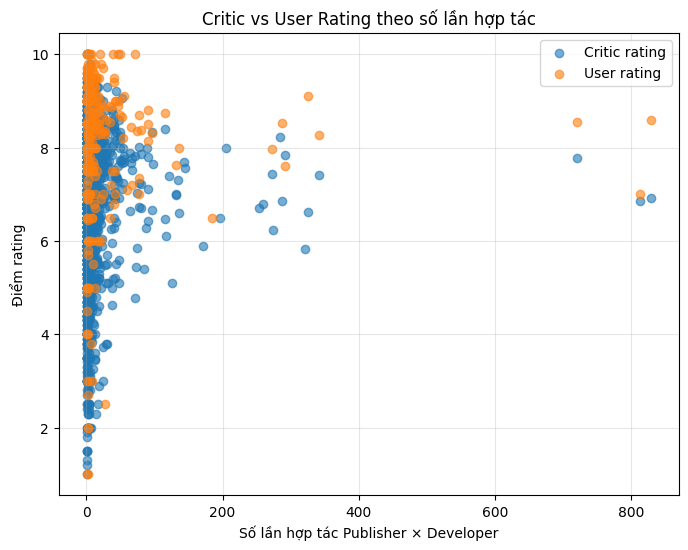

In [4]:
pairs = df_clean.groupby(['publisher', 'developer']).agg(
    critic_mean=('critic', 'mean'),
    user_mean=('user', 'mean'),
    sales_total=('total', 'sum'),
    count=('name', 'count')
).reset_index()



plt.figure(figsize=(8,6))

plt.scatter(
    pairs['count'],
    pairs['critic_mean'],
    alpha=0.6,
    label='Critic rating'
)

plt.scatter(
    pairs['count'],
    pairs['user_mean'],
    alpha=0.6,
    label='User rating'
)

plt.title("Critic vs User Rating theo số lần hợp tác")
plt.xlabel("Số lần hợp tác Publisher × Developer")
plt.ylabel("Điểm rating")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#### Nhận xét: 
1. Tần suất hợp tác thấp ($\le$ 10 lần): Đây là khu vực của rủi ro cao và tiềm năng cao. Các cặp hợp tác ít lần chiếm phần lớn dữ liệu và có sự phân tán điểm đánh giá rất rộng (từ thấp nhất đến 10/10). Điều này cho thấy:
- Nhiều dự án đột phá, sáng tạo hoặc đầu tư lớn là những lần hợp tác đơn lẻ/ít ỏi, dẫn đến điểm số cực cao.
- Cũng có nhiều dự án thất bại hoặc chất lượng kém ngay từ lần hợp tác đầu tiên, dẫn đến điểm số rất thấp.
2. Tần suất hợp tác cao ($>$ 100 lần): 
- Đây là khu vực của sự ổn định và thương hiệu. Các cặp hợp tác nhiều lần (thường là các chuỗi game/franchise) hiếm khi đạt được điểm số tuyệt đối ($\sim$ 9–10), nhưng điểm đánh giá của họ ổn định và tập trung chủ yếu ở mức trung bình-khá (khoảng 6–8).

3. Kết luận: 
- Việc hợp tác nhiều lần giữa Publisher và Developer giúp duy trì chất lượng ổn định và giảm thiểu rủi ro sản phẩm kém chất lượng, nhưng ít có khả năng tạo ra các siêu phẩm được đánh giá cao nhất.

Chất lượng hay thương hiệu quyết định doanh số?

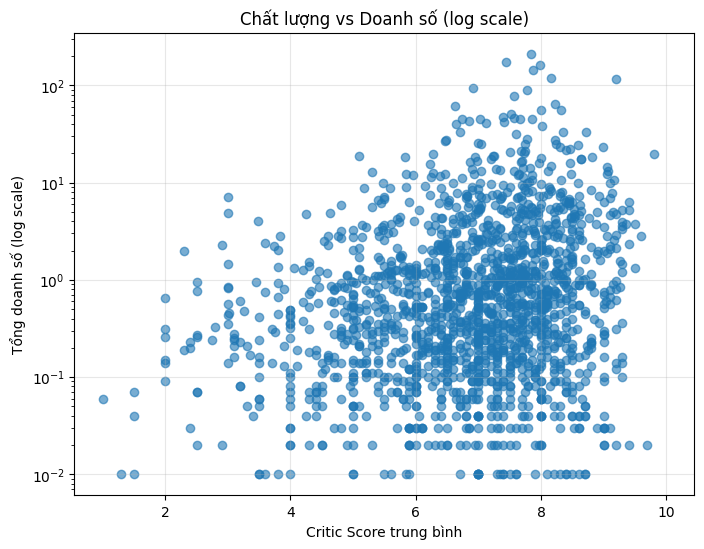

In [5]:
plt.figure(figsize=(8,6))
plt.scatter(pairs['critic_mean'], pairs['sales_total'], alpha=0.6)

plt.yscale('log')
plt.xlabel("Critic Score trung bình")
plt.ylabel("Tổng doanh số (log scale)")
plt.title("Chất lượng vs Doanh số (log scale)")
plt.grid(alpha=0.3)
plt.show()


####  Nhận xét:
1. Chất lượng không phải là yếu tố duy nhất quyết định doanh số nhưng có những kết luận khá rõ từ biểu đồ:
- Chất lượng thấp (Critic Score $< 4$): Gần như đảm bảo thất bại thương mại (doanh số thấp).
- Chất lượng trung bình-cao (Critic Score $\sim 6–8$): Doanh số biến động mạnh nhất. Một game chất lượng 7.0 có thể bán rất chạy hoặc rất tệ.

2. Kết luận: 
- Chất lượng  là điều kiện cần để tránh thất bại, nhưng Thương hiệu và Chiến lược Phân phối/Marketing (yếu tố do publisher mạnh chi phối) là điều kiện đủ và quyết định liệu game có thể đạt được doanh số bùng nổ hay không. Các cặp hợp tác lâu năm thường tạo dựng được thương hiệu mạnh, giúp họ có lợi thế lớn về mặt thương mại, ngay cả khi chất lượng game chỉ ở mức khá.

Có sự chênh lệch nhiều giữa điểm đánh giá của nhà phê bình so với người chơi theo số lần hợp tác không?

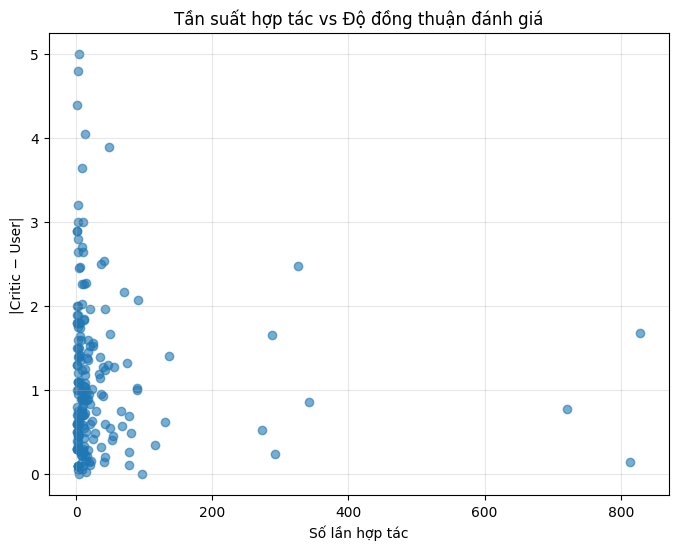

In [6]:
pairs['score_gap'] = abs(pairs['critic_mean'] - pairs['user_mean'])

plt.figure(figsize=(8,6))
plt.scatter(pairs['count'], pairs['score_gap'], alpha=0.6)

plt.xlabel("Số lần hợp tác")
plt.ylabel("|Critic − User|")
plt.title("Tần suất hợp tác vs Độ đồng thuận đánh giá")
plt.grid(alpha=0.3)
plt.show()


Biểu đồ thể hiện mối quan hệ giữa tần suất hợp tác của Publisher–Developer và độ lệch tuyệt đối giữa điểm đánh giá của giới phê bình và người chơi.
#### Nhận xét:
1. Tần suất hợp tác thấp:
- Độ lệch đánh giá rất lớn, cho thấy nhiều game gây tranh cãi (Critic và User nhìn nhận rất khác nhau). Đây là dấu hiệu của việc các sản phẩm đơn lẻ/thử nghiệm có thể làm hài lòng một nhóm nhưng gây thất vọng cho nhóm còn lại.
2. Tần suất hợp tác cao:
- Độ lệch đánh giá nhỏ hơn, cho thấy sự đồng thuận cao hơn giữa Critic và User. Sự hợp tác lâu dài giúp cặp đôi này hiểu rõ hơn về kỳ vọng của thị trường và có công thức sản xuất ổn định, ít gây ra sự phản ứng trái chiều.
3. Kết luận: Hợp tác lâu dài giữa Publisher-Developer giúp ổn định chất lượng và tăng độ đồng thuận trong đánh giá, giảm thiểu rủi ro sản phẩm gây tranh cãi.

### Trả lời tổng hợp cho câu hỏi 1:
Có, sự phối hợp giữa Publisher và Developer có ảnh hưởng rõ rệt đến hiệu quả game, nhưng theo một cách phức tạp:
1. Hợp tác Ít lần (Thấp): Dẫn đến biên độ rủi ro lớn (điểm rất cao hoặc rất thấp) và độ đồng thuận đánh giá thấp (nhiều game gây tranh cãi). Tuy nhiên, đây là nguồn gốc của các siêu phẩm được đánh giá cao nhất.
2. Hợp tác Nhiều lần (Cao): Dẫn đến chất lượng ổn định (điểm trung bình-khá) và độ đồng thuận đánh giá cao (ít game gây tranh cãi). Dù hiếm khi tạo ra các siêu phẩm về mặt điểm số, nhưng sự ổn định này thường đi kèm với thương hiệu mạnh, giúp họ giảm thiểu rủi ro và đảm bảo hiệu quả thương mại ổn định hoặc bùng nổ nếu có chiến lược marketing tốt.


### Lời khuyên chiến lược:
1. Dành cho Developer
- Tối đa hóa chất lượng và sự đột phá: Nếu mục tiêu là tạo ra siêu phẩm hoặc game mang tính đột phá, Developer nên cân nhắc hợp tác với nhiều Publisher khác nhau tùy theo thể loại game và tập trung tối đa vào chất lượng của dự án độc lập/đầu tiên.
- Đảm bảo sự ổn định Tài chính: Nếu mục tiêu là lợi nhuận lâu dài và giảm thiểu rủi ro, Developer nên xây dựng mối quan hệ đối tác lâu dài với một Publisher uy tín để duy trì chất lượng ổn định và giảm thiểu khả năng thất bại thảm hại.

2. Dành cho Publisher
- Săn tìm siêu phẩm: Publisher nên chủ động tìm kiếm các Developer mới cho các dự án đơn lẻ, sáng tạo (one-off projects) để săn tìm "viên kim cương thô" có tiềm năng đạt điểm đánh giá cực cao và tạo tiếng vang.
- Củng cố thương hiệu: Publisher cần đầu tư vào việc xây dựng và duy trì các mối quan hệ Developer cốt lõi để phát triển các chuỗi game ổn định. Đồng thời, sử dụng sức mạnh thương hiệu để đảm bảo doanh số bùng nổ cho các game có chất lượng từ trung bình khá trở lên, vì chất lượng đơn thuần không đảm bảo thành công thương mại.

## Câu hỏi 2: Theo thời gian, platform nào phát triển, platform nào "chết"?

### Motivation & Benefits
Platform cũng là một trong những yếu tố quyết định game có được tiêu thụ nhiều không, 

### Preprocessing
- Tách cột năm từ cột date
- Loại bỏ những dòng không có năm
- Tạo cột sale theo year của platform bằng cách lấy total, nếu dòng nào không có total thì lấy shipped, nếu không có xem là 0 và không phân tích được sale_trend
### Analysis
Trước tiên chúng em định nghĩa các khái niệm:
1. Platform phát triển khi:
- Số lượng game phát hành tăng theo thời gian 
- và/hoặc doanh số duy trì hoặc tăng

2. Platform suy giảm / “chết” khi:
- Số lượng game giảm dần
- Doanh số tiệm cận 0
- Không còn xuất hiện trong các năm gần đây <br>
Mục tiêu phân tích:
- Tìm hiểu xem các platform nào vẫn đang hoạt động và đang phát triển
- Phát hiện các platform tiềm năng


In [7]:
# --- BƯỚC 1: Chuẩn bị dữ liệu gốc ---
df_time = df_clean.copy()
df_time['date'] = pd.to_datetime(df_time['date'], errors='coerce')
df_time['year'] = df_time['date'].dt.year

# Loại bỏ platform không cần thiết và dòng không có năm
df_time = df_time[~df_time['platform'].isin(['Series', 'All'])]
df_time = df_time[df_time['year'].notna()]

# Tạo cột sale
df_time['sale'] = df_time['total'].fillna(df_time['shipped']).fillna(0)

# --- BƯỚC 2: Tạo platform_combined (Thứ tự quan trọng) ---
# 1. Tính số lượng game (game_count)
platform_year = df_time.groupby(['platform', 'year']).size().reset_index(name='game_count')

# 2. Tính tổng doanh thu (sales_sum)
platform_sales_year = df_time.groupby(['platform', 'year'])['sale'].sum().reset_index(name='sales_sum')

# 3. Merge lại thành platform_combined
platform_combined = platform_year.merge(platform_sales_year, on=['platform', 'year'])

# 4. Lọc Big Platforms (có >= 100 game)
big_platforms = platform_year.groupby('platform')['game_count'].sum()
big_platforms = big_platforms[big_platforms >= 100].index.tolist()

platform_combined_big = platform_combined[platform_combined['platform'].isin(big_platforms)]

#### A.Tuổi đời platform:
 - platform nào đã biến mất
 - platform nào còn tồn tại tới hiện tại

In [8]:
current_year = df_time['year'].max()

platform_summary = df_time.groupby('platform')['year'].agg(
    start_year='min',
    end_year='max',
    total_games='count'
).reset_index()

# Tuổi đời platform
platform_summary['life_span'] = platform_summary['end_year'] - platform_summary['start_year'] + 1

# Số năm không còn phát hành game
platform_summary['inactive_years'] = current_year - platform_summary['end_year']

# Trạng thái platform
platform_summary['status'] = platform_summary['inactive_years'].apply(
    lambda x: 'Active' if x <= 2 else 'Dead'
)


- inactive_years ≤ 2 → còn hoạt động
- inactive_years > 2 → xem như đã biến mất

Platform đã biến mất

In [9]:
dead_platforms = platform_summary[platform_summary['status'] == 'Dead'] \
    .sort_values('end_year')

dead_platforms

,platform,start_year,end_year,total_games,life_span,inactive_years,status
13,C128,1985,1985,1,1,39,Dead
15,CV,1981,1985,19,5,39,Dead
3,5200,1981,1987,69,7,37,Dead
10,ApII,1981,1987,2,7,37,Dead
33,MSX,1987,1988,2,2,36,Dead
...,...,...,...,...,...,...,...
41,OSX,1979,2020,261,42,4,Dead
71,iOS,2010,2020,71,11,4,Dead
55,SAT,1994,2021,722,28,3,Dead
64,WinP,2009,2021,22,13,3,Dead


Platform còn tồn tại tới hiện tại

In [10]:
active_platforms = platform_summary[platform_summary['status'] == 'Active'].sort_values('life_span', ascending=False)

active_platforms


,platform,start_year,end_year,total_games,life_span,inactive_years,status
43,PC,1970,2024,8939,55,0,Active
49,PS4,2013,2024,1985,12,0,Active
68,XOne,2013,2024,1311,12,0,Active
39,NS,2015,2024,1632,10,0,Active
50,PS5,2020,2024,141,5,0,Active
69,XS,2020,2024,119,5,0,Active


#### Nhận xét: 
- Có thể thấy trong những năm gần đây chỉ có một số ít platform còn hoạt động, cho thấy thị trường ngày càng thu hẹp.
- Nền tảng PC là nền tảng lâu đời và bền vững nhất.


#### B.Platform phát triển hay suy thoái theo thời gian
Mục tiêu
- Platform nào đang phát triển
- Platform nào đang suy thoái
- Platform nào ổn định nhưng không tăng trưởng

In [11]:
platform_year = df_time.groupby(['platform', 'year']).size().reset_index(name='game_count')
big_platforms = (
    platform_year.groupby('platform')['game_count']
    .sum()
    .reset_index()
)

big_platforms = big_platforms[big_platforms['game_count'] >= 100]['platform']

platform_year_big = platform_year[platform_year['platform'].isin(big_platforms)]

def calc_trend_full(x):
    x = x.sort_values('year')
    if len(x) < 2: # Tránh lỗi nếu platform chỉ có 1 năm hoạt động
        return pd.Series({'game_trend': 0, 'sales_trend': 0})
        
    mid = len(x) // 2
    # Tính toán trung bình 2 giai đoạn
    old_game_avg = x.iloc[:mid]['game_count'].mean()
    recent_game_avg = x.iloc[mid:]['game_count'].mean()
    
    old_sales_avg = x.iloc[:mid]['sales_sum'].mean()
    recent_sales_avg = x.iloc[mid:]['sales_sum'].mean()
    
    return pd.Series({
        'game_trend': recent_game_avg - old_game_avg,
        'sales_trend': recent_sales_avg - old_sales_avg
    })

# Áp dụng tính toán
full_trend = platform_combined_big.groupby('platform').apply(calc_trend_full).reset_index()
full_trend['game_status'] = full_trend['game_trend'].apply(
    lambda x: 'Growing' if x > 1 else ('Declining' if x < -1 else 'Stable')
)
full_trend = full_trend.sort_values('game_trend', ascending=False)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_3152\1312134727.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  full_trend = platform_combined_big.groupby('platform').apply(calc_trend_full).reset_index()


Platform đang phát triển

In [12]:
print(full_trend[full_trend['game_status'] == 'Growing'].sort_values('game_trend', ascending=False))

   platform  game_trend  sales_trend game_status
40      XBL  201.800000     0.254333     Growing
20       PC  198.291667    39.354583     Growing
6      DSiW   57.333333     0.000000     Growing
19      OSX   22.511111    -0.014444     Growing
11       GG   22.416667    -0.013333     Growing
16      NES   17.428571   -20.120000     Growing
10      GEN   12.619048    -0.808095     Growing
1       3DO    8.000000    -0.495000     Growing
7        GB    5.000000    -3.800536     Growing


Platform ổn định

In [13]:
print(full_trend[full_trend['game_status'] == 'Stable'])

Empty DataFrame
Columns: [platform, game_trend, sales_trend, game_status]
Index: []


platform suy thoái

In [14]:
print(full_trend[full_trend['game_status'] == 'Declining'].sort_values('game_trend'))

   platform  game_trend  sales_trend game_status
23      PS2 -244.928571  -130.582321   Declining
18       NS -228.900000   -44.361500   Declining
5        DS -224.571429   -69.832857   Declining
36      Wii -205.857143  -123.439821   Declining
27      PSN -187.266667    -0.668333   Declining
22       PS -183.375000   -73.620000   Declining
8       GBA -174.750000   -51.710000   Declining
28      PSP -122.857143   -32.288571   Declining
30      SAT -114.500000    -6.267500   Declining
33       VC -111.850000    -0.056000   Declining
25      PS4 -110.500000  -122.308333   Declining
38     X360 -101.767857   -74.090000   Declining
2       3DS  -98.200000   -36.300000   Declining
4        DC  -87.125000    -2.379643   Declining
9        GC  -73.750000   -26.480000   Declining
39       XB  -70.250000   -34.005000   Declining
32     SNES  -68.904762   -15.957143   Declining
41     XOne  -67.500000   -50.251667   Declining
24      PS3  -51.678571   -54.623036   Declining
35       WW  -49.500

Biểu đồ xu hướng:
- Lấy 5 platform có game trend cao nhất

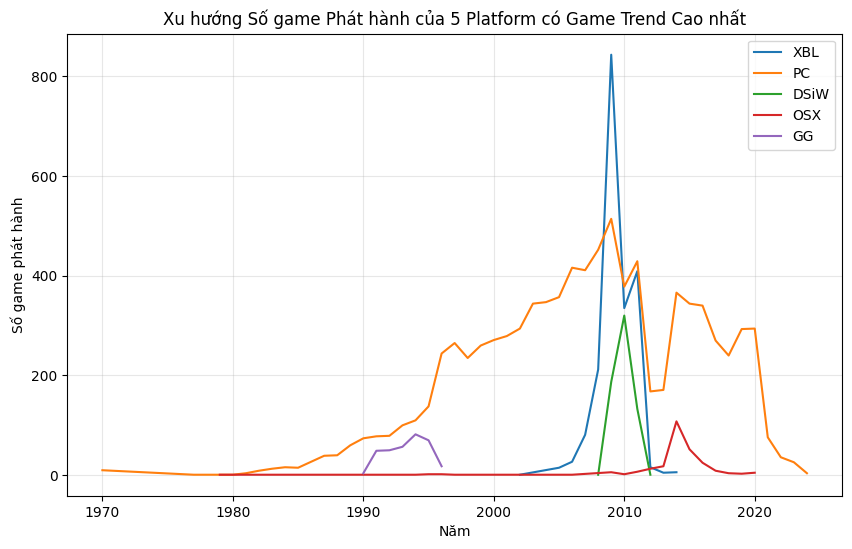

In [15]:
plt.figure(figsize=(10,6))
top_5_platforms = full_trend.sort_values('game_trend', ascending=False).head(5)['platform']

for p in top_5_platforms:

    temp = platform_year_big[platform_year_big['platform'] == p]
    plt.plot(temp['year'], temp['game_count'], label=p)

plt.xlabel("Năm")
plt.ylabel("Số game phát hành")
plt.title("Xu hướng Số game Phát hành của 5 Platform có Game Trend Cao nhất")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

#### Nhận xét:
- Đa số những platform bùng nổ số game phát hành đều có tuổi đời khá ngắn, chỉ có PC khá ổn định và vẫn còn active đến thời gian gần nhất, tất cả còn lại đều dead.

#### C. Platform tiềm năng
Gồm những platform 
- Mới ra mắt trong 10 năm gần đây
- Active (vẫn ra game trong 2 năm gần nhất)
- Ra game ngày càng nhiều (game trend dương)
- Doanh số giai đoạn sau tăng so với giai đoạn đầu (sale trend dương)

In [16]:
emerging = platform_summary.merge(full_trend, on='platform')
N = 10 
sales_driven_potential = emerging[
    (emerging['status'] == 'Active') &  
    (emerging['start_year'] >= (current_year - N)) &
    (emerging['sales_trend'] > 0) & (emerging['game_trend'] > 1)
].sort_values('sales_trend', ascending=False)
print(f"--- Platform tiềm năng (ra mắt dưới 10 năm, active  & sales tăng) ---")
print(sales_driven_potential)

# Xem các platform Active và Mới (10 năm)
recently_active = emerging[
    (emerging['status'] == 'Active') &  
    (emerging['start_year'] >= (current_year - 10))
]

print("\nPlatform mới ( ra mắt dưới 10 năm) và active: xem chúng thiếu gì mà không tiềm năng:")
print(recently_active[['platform', 'start_year', 'game_trend', 'sales_trend']])

--- Platform tiềm năng (ra mắt dưới 10 năm, active  & sales tăng) ---
Empty DataFrame
Columns: [platform, start_year, end_year, total_games, life_span, inactive_years, status, game_trend, sales_trend, game_status]
Index: []

Platform mới ( ra mắt dưới 10 năm) và active: xem chúng thiếu gì mà không tiềm năng:
   platform  start_year  game_trend  sales_trend
18       NS        2015 -228.900000   -44.361500
26      PS5        2020  -35.500000     0.990000
42       XS        2020  -38.666667     1.013333


 #### Trả lời tổng hợp cho câu hỏi 2: 
  1. Phân tích tuổi đời và chu kỳ sống
  - Sự thống trị của PC: PC nổi bật là nền tảng có tuổi đời dài nhất (55 năm), chứng tỏ khả năng thích ứng vượt thời gian và duy trì vị thế là nền tảng vật lý cốt lõi.
  - Chu kỳ Console: Các platform "Dead" (như PS2, WiiU, PSP) xác nhận rõ ràng chu kỳ sống của console, trong đó mỗi thế hệ mới (PS5, XS) sẽ thay thế thế hệ cũ, đẩy chúng vào trạng thái suy thoái và ngừng hỗ trợ phát triển.
  2. Xu hướng phát triển và suy thoái (trend kép)
  Phân tích xu hướng kép là công cụ quan trọng để đánh giá sức khỏe toàn diện của một platform (Developer Focus qua game_trend và Consumer Spending qua sales_trend)
  A. Platform Phát triển Mạnh mẽ 
  - PC: Là platform duy nhất trong số các platform lớn thể hiện sự tăng trưởng kép mạnh mẽ và bền vững nhất về cả số lượng game ($\text{game\_trend} \approx 198.3$) và doanh số ($\text{sales\_trend} \approx 4.515$). 
  - Một số platform cũ (như GEN, GB) vẫn ghi nhận mức tăng trưởng doanh số và game dương, nghĩa là ở giai đoạn sau của vòng đời thì nó đã tăng doanh thu và số game ra mắt nhưng cũng suy thoái nhanh chóng.
  B. Platform suy thoái kép 
  - Dấu hiệu chuyển giao: Các platform như PS2, Wii, X360, và đáng chú ý là PS4/XOne đều đã bước vào giai đoạn suy thoái kép (cả $\text{game\_trend}$ và $\text{sales\_trend}$ đều giảm mạnh). Đây là dấu hiệu rõ ràng của việc kết thúc chu kỳ kinh doanh và sự chuyển giao thế hệ đang diễn ra.
  3. Đánh giá platform tiềm năng 
  - Việc lọc platform tiềm năng (mới ra mắt trong 10 năm, Active, Game Trend $> 1$, Sales Trend $> 0$) trả về empty DataFrame cho thấy thị trường platform đang ổn định và không có nhân tố tiềm năng.
- Nguyên nhân bị loại:
  - Nintendo Switch (NS): Mặc dù là platform gần đây, NS đã đi qua đỉnh phát triển, dẫn đến $\text{game\_trend}$ và $\text{sales\_trend}$ hiện tại đều âm ($\approx -228.9$ và $\approx -44.361$) so với giai đoạn bùng nổ trước đó.
  - PS5/XS: Các console mới nhất hiện chỉ thể hiện xu hướng $\text{game\_trend}$ giảm và $\text{sales\_trend}$ có tăng nhẹ, không đạt mức tăng trưởng dương mạnh mẽ so với nửa đầu vòng đời. Điều này có thể do dữ liệu còn quá mới hoặc sự phân bổ nguồn lực ban đầu quá cao.
#### Lời khuyên chiến lược cho nhà phát triển
- Ưu tiên kép: Nhà phát triển nên coi PC là lựa chọn đầu tư an toàn và tiềm năng nhất về mặt tăng trưởng kép và tuổi thọ.
- Chiến lược console: Mặc dù các platform mới (PS5, XS) không đáp ứng tiêu chí "tăng trưởng kép" hiện tại, chúng vẫn là nơi người tiêu dùng đang chi tiêu và là thị trường không thể bỏ qua. Developer cần tiếp tục đầu tư vào các hệ máy này như một phần của chiến lược đa nền tảng cốt lõi.
- Tránh đầu tư lãng phí: Cần nhanh chóng chuyển hướng nguồn lực khỏi các platform đã bước vào giai đoạn suy thoái Kép (như PS4 và XOne) để tối đa hóa hiệu quả đầu tư.

## Câu hỏi 3: Các khu vực như Bắc Mỹ, châu Âu, Nhật Bản có mô hình tiêu thụ game khác nhau như thế nào giữa các nền tảng, và nền tảng nào thể hiện sự vượt trội rõ rệt tại từng khu vực?

### Động lực & Lợi ích
- Thị trường game toàn cầu không đồng nhất. Nhu cầu, sở thích và sự thâm nhập của các nền tảng console/PC/thiết bị di động khác nhau đáng kể giữa các khu vực. Phân tích này giúp định lượng sự khác biệt đó.
- Cung cấp cái nhìn trực quan về sự phân bổ sức mạnh thị trường của các nền tảng theo khu vực. Giúp xác định các nền tảng "thống trị" hoặc "yếu thế" tại từng thị trường cụ thể.
- Nhà phát triển và Nhà phát hành Game (Stakeholders): Giúp họ quyết định nền tảng (Platform) nào cần ưu tiên phát hành hoặc marketing mạnh mẽ hơn ở từng khu vực (ví dụ: một game thiên về RPG có thể tập trung vào thị trường Nhật Bản/châu Âu trên nền tảng A). Nhà sản xuất Console/Phần cứng (Decision-makers): Đánh giá hiệu suất thị trường của thiết bị của họ so với đối thủ cạnh tranh ở các khu vực địa lý khác nhau. Nhà nghiên cứu thị trường: Hiểu rõ xu hướng tiêu thụ game toàn cầu.
- Thông báo quyết định Phân bổ Nguồn lực và Chiến lược Phát hành Toàn cầu. Thay vì áp dụng chiến lược "one-size-fits-all", công ty có thể điều chỉnh ngân sách tiếp thị và tối ưu hóa nền tảng cho từng thị trường khu vực.

### Preprocessing 
- Mục tiêu: Đảm bảo chỉ phân tích các hàng dữ liệu thể hiện doanh số bán lẻ cá nhân của trò chơi theo khu vực, loại bỏ các mục tổng hợp (ví dụ: platform = 'Series') hoặc các hàng không có dữ liệu doanh số khu vực.

- Bước 1: Xác định các cột Doanh số: Định nghĩa một danh sách các cột doanh số khu vực và tổng (sales_cols = ["america", "europe", "japan", "other", "total"]).

- Bước 2: Lọc bỏ Hàng thiếu: Sử dụng phương pháp df.dropna() với tham số subset=sales_cols và how="all" để chỉ giữ lại các hàng có ít nhất một giá trị doanh số khu vực hoặc tổng. Điều này giúp loại bỏ các mục tổng hợp cấp cao mà không chứa thông tin chi tiết khu vực.

### Analysis
- Mục tiêu: So sánh sự khác biệt về sức mạnh thị trường của các nền tảng bằng cách sử dụng Doanh số bán hàng trung bình.

- Phương pháp (Thống kê Mô tả): Tính toán Doanh số Trung bình của từng khu vực ("america", "europe", "japan", "other") cho mỗi platform bằng cách sử dụng hàm groupby().mean(). Doanh số trung bình giúp chuẩn hóa và làm giảm ảnh hưởng của số lượng game được phát hành trên mỗi nền tảng.

- Phương pháp (Tìm kiếm Đỉnh cao): Xác định nền tảng mạnh nhất (idxmax()) cho từng khu vực để trả lời phần hai của câu hỏi (nền tảng nào vượt trội rõ rệt).

- Phương pháp (Trực quan hóa):

    Biểu đồ Cột (Bar Chart): Hiển thị rõ ràng sự khác biệt về độ lớn của doanh số trung bình giữa các nền tảng và khu vực.

    Biểu đồ Nhiệt (Heatmap): Cung cấp một cái nhìn tổng quan, trực quan về mô hình tiêu thụ (pattern) giữa các cặp Platform-Khu vực. Màu sắc đậm hơn biểu thị doanh số trung bình cao hơn, làm nổi bật ngay lập tức các thị trường thống trị của từng nền tảng.

Số dòng còn lại sau khi lọc: 18915
           america    europe     japan     other
platform                                        
GEN       1.394444  0.404444  0.093182  0.038125
DC        1.125000  0.305000  0.156809  0.007407
GB        0.920000  0.500000  0.366739  0.007368
GBC       0.895000  0.525000  0.460000  0.040000
SNES      0.570000  0.132727  0.296062  0.002680


<Figure size 1400x800 with 0 Axes>

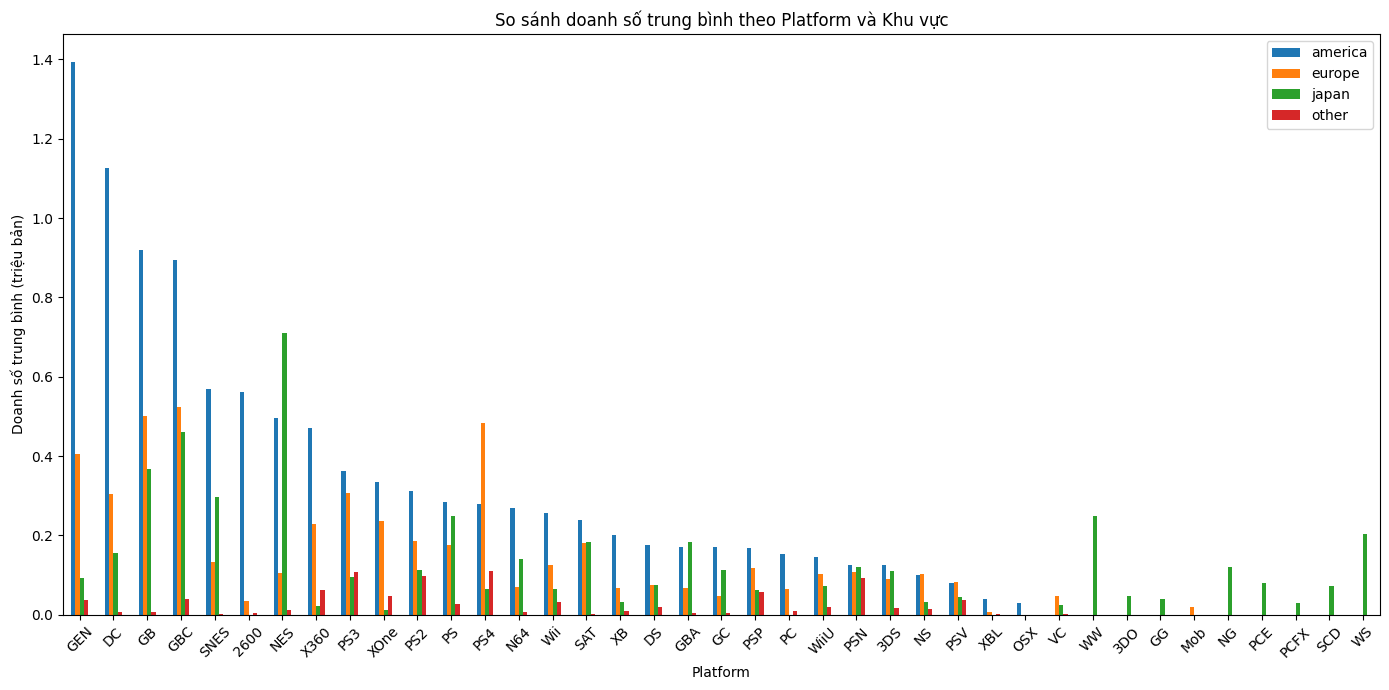


=== Nền tảng mạnh nhất theo từng khu vực ===
America: GEN
Europe: GBC
Japan: NES
Other: PS4


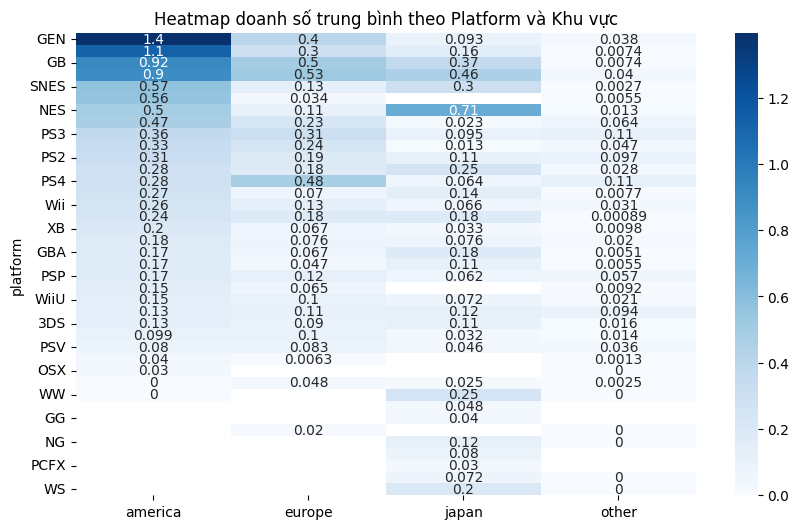

In [17]:
# 1. Chỉ giữ những dòng có đủ thông tin doanh số
# (Tránh các dòng platform = 'Series' hoặc không có sales theo khu vực)
sales_cols = ["america", "europe", "japan", "other", "total"]
df_sales = df.dropna(subset=sales_cols, how="all")

print("Số dòng còn lại sau khi lọc:", len(df_sales))

# 2. Tính doanh số trung bình theo từng nền tảng
platform_region_mean = df_sales.groupby("platform")[["america", "europe", "japan", "other"]].mean().sort_values("america", ascending=False)
print(platform_region_mean.head())

# 3. VẼ BIỂU ĐỒ SO SÁNH DOANH SỐ GIỮA CÁC PLATFORM THEO TỪNG KHU VỰC
plt.figure(figsize=(14,8))
platform_region_mean.plot(kind="bar", figsize=(14, 7))
plt.title("So sánh doanh số trung bình theo Platform và Khu vực")
plt.xlabel("Platform")
plt.ylabel("Doanh số trung bình (triệu bản)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. TÌM NỀN TẢNG MẠNH NHẤT Ở MỖI KHU VỰC
best_platforms = {
    "America": platform_region_mean["america"].idxmax(),
    "Europe": platform_region_mean["europe"].idxmax(),
    "Japan": platform_region_mean["japan"].idxmax(),
    "Other": platform_region_mean["other"].idxmax()
}

print("\n=== Nền tảng mạnh nhất theo từng khu vực ===")
for region, plat in best_platforms.items():
    print(f"{region}: {plat}")

# 5. HEATMAP để xem pattern tiêu thụ giữa region-platform
plt.figure(figsize=(10,6))
sns.heatmap(platform_region_mean, annot=True, cmap="Blues")
plt.title("Heatmap doanh số trung bình theo Platform và Khu vực")
plt.show()


### Results & Interpretation
1. Nền tảng Mạnh nhất cho từng khu vực:

Mô hình tiêu thụ game phân cực mạnh mẽ giữa phương Tây và Nhật Bản, với các nền tảng vượt trội về doanh số trung bình như sau:

America: GEN (1.39 triệu bản/game)

Europe: GBC (0.525 triệu bản/game)

Japan: NES (0.723 triệu bản/game)

Other: PS4 (0.028 triệu bản/game)

2. Diễn giải Mô hình Tiêu thụ:

Phân cực Thị trường: America và Europe có mô hình tương đồng, trong khi Japan là thị trường độc lập, ưa chuộng các nền tảng Nintendo cổ điển (NES, GBC, SNES).

Sức mạnh của Retro: Các nền tảng đời đầu (GEN, DC, GB) chiếm ưu thế cao về doanh số trung bình, cho thấy sự ảnh hưởng của các "bom tấn" lịch sử hoặc các vấn đề dữ liệu liên quan đến việc gộp "Series".

GBC thể hiện sự cân bằng tốt nhất, có doanh số cao ở cả ba khu vực chính.

3. Hàm ý thực tế:

Nhà phát hành cần áp dụng chiến lược đa dạng: ưu tiên Nintendo tại Nhật Bản và tập trung vào các nền tảng console/PC tại phương Tây để tối đa hóa lợi nhuận theo từng khu vực. Cần điều tra lại sự thống trị của các nền tảng quá cũ (GEN, DC) để đảm bảo chất lượng dữ liệu.

## Câu hỏi 4: Xu hướng phát hành và doanh số game thay đổi như thế nào theo từng năm? Liệu có thể quan sát được các mô hình dài hạn của thị trường game qua thời gian hay không?

### Motivation & Benefits
- Sự phát triển của ngành công nghiệp game phụ thuộc vào các chu kỳ phát hành console và sự thay đổi trong hành vi người tiêu dùng. Phân tích này giúp định vị các giai đoạn bùng nổ và suy thoái của thị trường.
- Xác định chu kỳ sống (Life Cycle) của thị trường game (ví dụ: các đỉnh điểm doanh số tương ứng với các thế hệ console). Đo lường mối quan hệ giữa số lượng sản phẩm (games released) và sức khỏe thị trường (total sales).
- Nhà đầu tư và Phân tích Thị trường: Đánh giá độ rủi ro và tiềm năng tăng trưởng của ngành game, xác định thời điểm đầu tư tối ưu. * Nhà phát triển game: Hiểu được sự cạnh tranh thay đổi như thế nào theo năm (thông qua số lượng game phát hành). Giám đốc điều hành: Xây dựng chiến lược dài hạn dựa trên chu kỳ thị trường.
- Thông báo quyết định Lập kế hoạch Sản phẩm và Cấu trúc Thị trường (Product Planning and Market Structuring). Dự đoán thời điểm bão hòa của thị trường và chuẩn bị cho các đợt suy thoái/tái cấu trúc.

### Preprocessing
- Mục tiêu: Chuẩn bị dữ liệu cho phân tích chuỗi thời gian, đảm bảo rằng mỗi dòng đều có thông tin cần thiết về thời gian và doanh số khu vực.

- Bước 1: Lọc bỏ Hàng thiếu: Lọc bỏ các hàng thiếu giá trị trong bất kỳ cột nào sau đây: "year", "total", "america", "europe", "japan", "other" (sử dụng how="any"). Việc này đảm bảo chỉ phân tích các game có đầy đủ dữ liệu doanh số khu vực và năm phát hành.

- Bước 2: Chuyển đổi Kiểu dữ liệu: Chuyển đổi cột "year" từ kiểu dữ liệu chuỗi/float sang kiểu số nguyên (int) để đảm bảo việc phân nhóm và vẽ biểu đồ thời gian được chính xác.


### Analysis
- Mục tiêu: Khám phá xu hướng dài hạn của thị trường bằng cách theo dõi sự thay đổi của tổng doanh số và số lượng game được phát hành theo năm.

- Phương pháp (Tổng hợp Dữ liệu Thời gian): Tính tổng doanh số cho mỗi khu vực và tổng toàn cầu (total) theo từng năm (groupby("year").sum()).

- Phương pháp (Đo lường Cung): Đếm số lượng game được phát hành mỗi năm (groupby("year").count()) để đo lường mức độ cạnh tranh và cung cấp sản phẩm.

- Phương pháp (Tương quan): Tính hệ số tương quan Pearson giữa Tổng Doanh số và Số lượng Game Phát hành theo năm. Hệ số này giúp định lượng mối quan hệ: liệu việc phát hành nhiều game hơn có đồng nghĩa với doanh số cao hơn trên toàn thị trường hay không.

- Phương pháp (Trực quan hóa): Sử dụng Biểu đồ Đường (Line Plots) để dễ dàng xác định các đỉnh, đáy và mô hình dài hạn (ví dụ: tăng trưởng, bão hòa, suy giảm) của doanh số và số lượng game theo thời gian.

C:\Users\Administrator\AppData\Local\Temp\ipykernel_3152\1712490135.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_year["year"] = df_year["year"].astype(int)


Số dòng còn lại sau khi lọc: 2222
5 dòng đầu của bảng doanh số theo năm:
      total  america  europe  japan  other
year                                      
1985   0.82     0.42    0.10   0.28   0.02
1986   2.28     0.66    0.17   1.43   0.02
1987   2.04     0.99    0.14   0.89   0.02
1988   0.96     0.32    0.06   0.57   0.01
1989   4.17     3.38    0.44   0.31   0.04


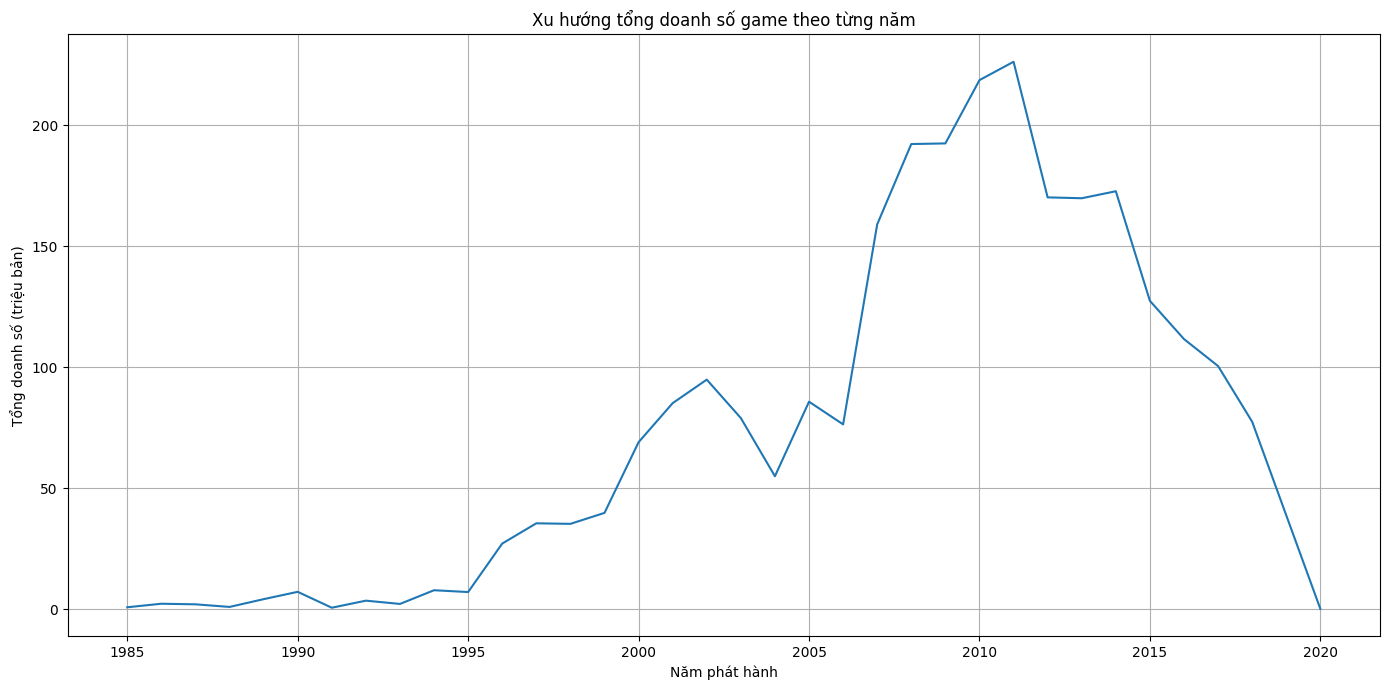

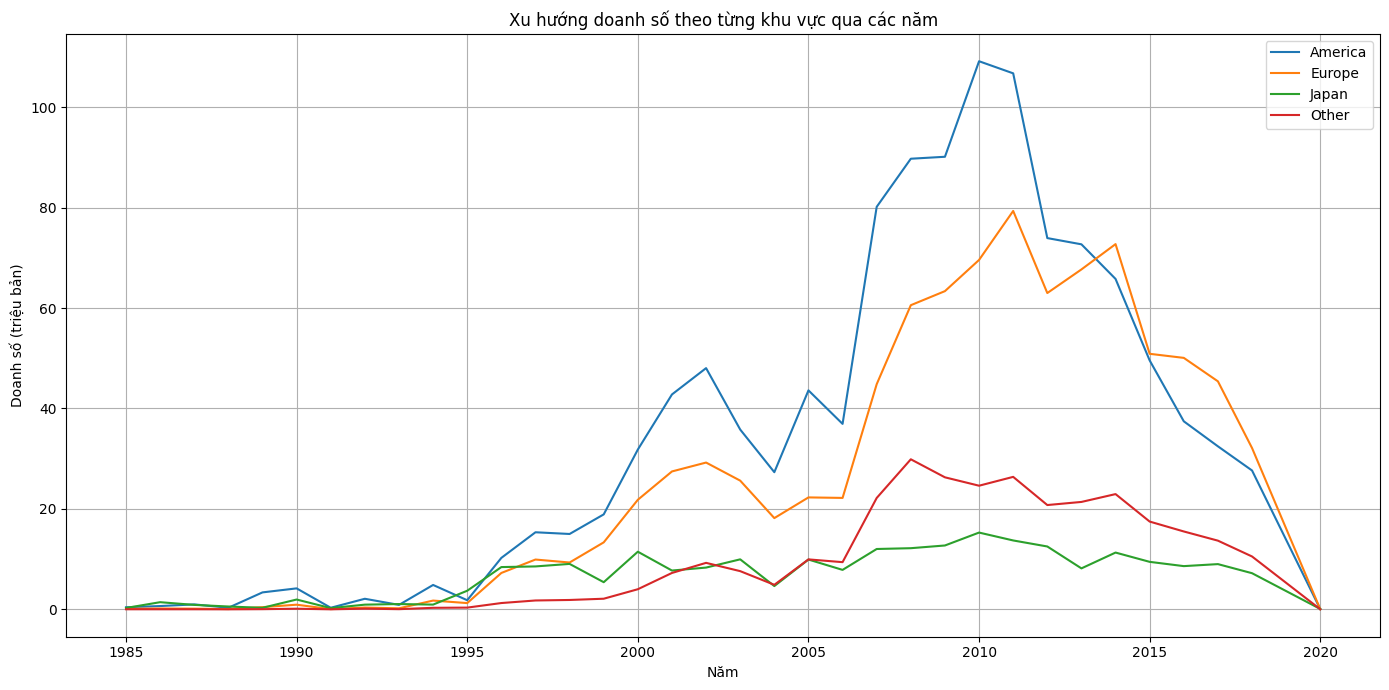

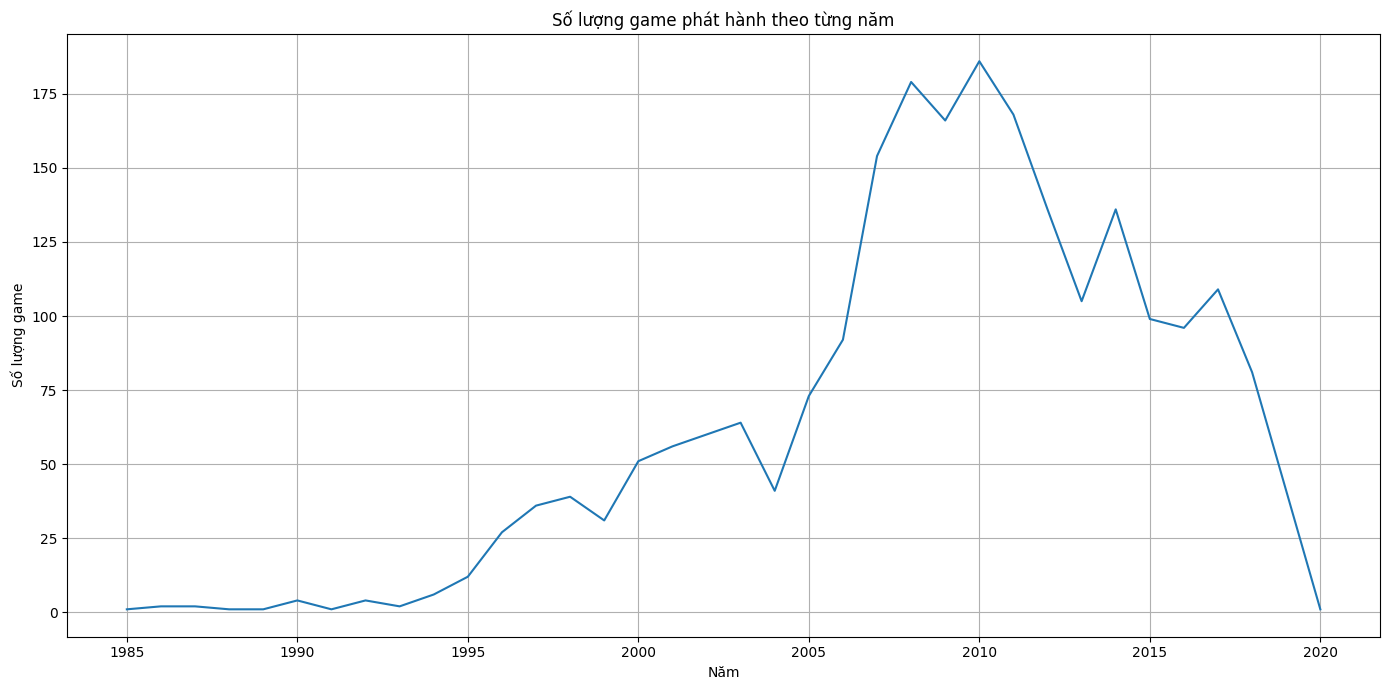


5 dòng đầu của bảng xu hướng:
      total_sales  games_released
year                             
1985         0.82               1
1986         2.28               2
1987         2.04               2
1988         0.96               1
1989         4.17               1

Hệ số tương quan giữa số game phát hành và tổng doanh số: 0.98


In [18]:
# 1. Lọc các dòng có thông tin năm và có doanh số
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# Extract year from date
df["year"] = df["date"].dt.year

year_cols = ["year", "total", "america", "europe", "japan", "other"]
df_year = df.dropna(subset=year_cols, how="any")

# Chuyển year sang int nếu cần
df_year["year"] = df_year["year"].astype(int)

print("Số dòng còn lại sau khi lọc:", len(df_year))

# 2. Tính doanh số trung bình theo từng năm
yearly_sales = df_year.groupby("year")[["total", "america", "europe", "japan", "other"]].sum()

print("5 dòng đầu của bảng doanh số theo năm:")
print(yearly_sales.head())

# 3. Vẽ biểu đồ đường theo thời gian — tổng doanh số toàn cầu
plt.figure(figsize=(14,7))
plt.plot(yearly_sales.index, yearly_sales["total"])
plt.title("Xu hướng tổng doanh số game theo từng năm")
plt.xlabel("Năm phát hành")
plt.ylabel("Tổng doanh số (triệu bản)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Vẽ biểu đồ đường cho từng khu vực
plt.figure(figsize=(14,7))
plt.plot(yearly_sales.index, yearly_sales["america"], label="America")
plt.plot(yearly_sales.index, yearly_sales["europe"], label="Europe")
plt.plot(yearly_sales.index, yearly_sales["japan"], label="Japan")
plt.plot(yearly_sales.index, yearly_sales["other"], label="Other")

plt.title("Xu hướng doanh số theo từng khu vực qua các năm")
plt.xlabel("Năm")
plt.ylabel("Doanh số (triệu bản)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Phân tích số lượng game phát hành mỗi năm
games_per_year = df_year.groupby("year")["platform"].count()

plt.figure(figsize=(14,7))
plt.plot(games_per_year.index, games_per_year.values)
plt.title("Số lượng game phát hành theo từng năm")
plt.xlabel("Năm")
plt.ylabel("Số lượng game")
plt.grid(True)
plt.tight_layout()
plt.show()

# 6. Kết hợp để xem năm nào 'bùng nổ' game
trend_df = pd.DataFrame({
    "total_sales": yearly_sales["total"],
    "games_released": games_per_year
})

print("\n5 dòng đầu của bảng xu hướng:")
print(trend_df.head())

# Tương quan giữa số game phát hành và doanh số
corr = trend_df.corr().iloc[0,1]
print(f"\nHệ số tương quan giữa số game phát hành và tổng doanh số: {corr:.2f}")


### Results & Interpretation
1. Trả lời Câu hỏi Trực tiếp:
Xu hướng phát hành và doanh số game thể hiện rõ ràng mô hình chu kỳ mạnh mẽ của thị trường, được dẫn dắt bởi các chu kỳ phát hành console.
- Tổng Doanh số (Total Sales): Thị trường game đạt đỉnh cao rõ rệt vào khoảng năm 2010-2011, với tổng doanh số hàng năm vượt qua 200 triệu bản. Sau đó, thị trường bước vào giai đoạn suy thoái đáng kể, giảm mạnh về cuối thời kỳ dữ liệu (2018-2020).
- Số lượng Game Phát hành: Số lượng game phát hành cũng đạt đỉnh vào khoảng năm 2010, tương ứng với đỉnh doanh số. Điều này xác nhận rằng việc tăng trưởng cung cấp sản phẩm đã song hành với nhu cầu thị trường.
- Mối quan hệ Cung-Cầu: Hệ số tương quan giữa số lượng game phát hành và tổng doanh số là $0.98$, cho thấy một mối quan hệ tích cực gần như hoàn hảo giữa hai yếu tố này.
2. Mô hình Dài hạn và Khu vực:
- Động lực Chính: Biểu đồ xu hướng doanh số theo khu vực  cho thấy thị trường America và Europe là hai động lực chính, chiếm phần lớn doanh số toàn cầu và quyết định đỉnh điểm thị trường vào năm 2010-2011.
- Thị trường Nhật Bản: Doanh số của Japan ổn định hơn, nhưng có sự tăng trưởng nhẹ và duy trì một khoảng cách đáng kể so với America/Europe.
- Hàm ý: Thị trường game hoạt động theo chu kỳ console rõ ràng, với đỉnh doanh số thường xảy ra khi các console thế hệ thứ 7 (PS3/Xbox 360/Wii) đạt độ bão hòa và có một thư viện game khổng lồ. Sự sụt giảm sau đó có thể do sự chuyển đổi sang các mô hình doanh thu khác (như game kỹ thuật số, Free-to-Play, Mobile) không được thống kê đầy đủ trong dữ liệu bán lẻ vật lý này.

## Câu hỏi 5: “Game được đánh giá cao (critic/user/VGC) có thực sự bán chạy hơn không, ở mức toàn cầu và từng khu vực?”

### Motivation & Benefits
- Trong ngành game, điểm đánh giá từ giới phê bình, người chơi và các trang tổng hợp (như VGC) thường được dùng trong marketing (gắn nhãn 9/10, Game of the year,...). Tuy nhiên không rõ Điểm cao có thực sự chuyển hóa thành doanh số hay chỉ mang tính danh tiếng.Mối quan hệ này mạnh hay yếu và khác nhau thế nào giữa các khu vực (America, Europe, Japan, Other). Việc trả lời được câu hỏi này sẽ giúp ta được vấn đề cơ bản là "Đầu tư thêm để nâng cao chất lượng/điểm đánh giá có thực sự mang lại tiền"

### Preprocessing
Mục tiêu tiền xử lí
- Chỉ giữ lại các bản dòng có 'total' hoặc doanh số các vùng không phải là NaN để phân tích
- Tạo một biến mới global_sales là trộn thông tin total và doanh số theo vùng

Quy trình tiền xử lý 
- Bước 1: Tạo bản sao dữ liệu gốc mục đích tránh làm thay đổi dataframe gốc nếu sau này cần dùng lại cho bài toán khác.
- Bước 2: Xóa các dòng có platform là "Series" hoặc "All" lý do vì đây là các bản ghi tổng hợp cho cả series hoặc cho toàn bộ nền tảng vì câu hỏi phân tích tập trung vào mối quan hệ điểm – doanh số của từng bản phát hành trên một platform cụ thể, nên giữ các bản ghi tổng hợp sẽ gây trùng/khó diễn giải.
- Bước 3: Loại bỏ các dòng hoàn toàn không có thông tin doanh số tức là loại bỏ dòng nếu tất cả cột 'total', 'america', 'europe','japan','other' đều mang giá trị NaN
- Bước 4: Tạo biến doanh số toàn cầu thống nhất global_sales mặc định lấy total, nếu bị thiếu thì sẽ lấy tổng các vùng còn lại vì một số bản ghi chỉ có total, số khác chỉ có doanh số theo vùng nên biến này giúp ta có một biến duy nhất đại diện cho doanh số toàn cầu “tốt nhất có thể” từ mọi nguồn dữ liệu sẵn có.

### Analysis

Mục tiêu phân tích
- Xem mức độ tương quan tuyến tính giữa điểm số và doanh số toàn cầu.
- Quan sát hình dạng mối quan hệ qua scatter plot.
- Kiểm tra xu hướng “điểm cao → doanh số trung bình cao hơn” bằng cách nhóm điểm thành các khoảng.
Các bước phân tích
- Tính ma trận tương quan global_sales,critic,user,vgc để xem một cách trực quan về sự tương quan mối quan hệ giữa các biến đánh giá so với biến global_sales
- Vẽ 3 biểu đồ scatter plot của từng biến đánh giá so với global_sales vì biểu đồ này dễ dàng nhận thấy quan hệ tuyến tính
- Chia theo khoảng điểm của 3 cột đánh giá và so sánh doanh số trung bình theo nhóm điểm và trực quan bằng biểu đồ bar, vì Scatter thể hiện những điểm dữ liệu riêng biệt nên rất nhiễu, khi lấy trung bình theo nhóm điểm thì làm giảm ảnh hưởng của outlier,

In [19]:

# Sao chép toàn bộ df để làm việc mà không ảnh hưởng đến df gốc
df_analysis = df.copy()

# Các cột vùng và numeric
region_cols = ['america', 'europe', 'japan', 'other']
score_cols = ['vgc', 'critic', 'user']
num_cols = ['shipped', 'total'] + region_cols + score_cols

# ======================
# 2. Lọc dữ liệu phù hợp với câu hỏi
# ======================

# Bỏ các dòng 'Series' và 'All' vì không phải platform cụ thể
df_analysis = df_analysis[~df_analysis['platform'].isin(['Series', 'All'])].copy()

# Bỏ những dòng hoàn toàn không có thông tin doanh số
# (cả total và 4 vùng đều NaN)
df_analysis = df_analysis.dropna(subset=['total'] + region_cols, how='all').copy()

# Tạo biến "global_sales": doanh số toàn cầu tốt nhất có thể
# - Nếu 'total' có thì dùng
# - Nếu 'total' thiếu mà các vùng có số liệu thì dùng tổng các vùng
df_analysis['regions_sum'] = df_analysis[region_cols].sum(axis=1, min_count=1)
df_analysis['global_sales'] = df_analysis['total']
mask = df_analysis['global_sales'].isna() & df_analysis['regions_sum'].notna()
df_analysis.loc[mask, 'global_sales'] = df_analysis.loc[mask, 'regions_sum']

# Giữ lại những dòng có global_sales để phân tích mối quan hệ với điểm
df_trim = df_analysis[df_analysis['global_sales'].notna()].copy()



In [20]:
print("Mô tả thống kê cho doanh số & điểm số:")
print(df_trim[['global_sales'] + score_cols].describe())



Mô tả thống kê cho doanh số & điểm số:
       global_sales         vgc       critic        user
count  18915.000000  798.000000  4098.000000  161.000000
mean       0.349190    7.406642     7.097438    8.102484
std        0.807591    1.403846     1.438520    1.353004
min        0.000000    2.000000     1.000000    2.500000
25%        0.030000    6.700000     6.300000    7.500000
50%        0.120000    7.700000     7.300000    8.300000
75%        0.345000    8.500000     8.100000    9.000000
max       20.320000    9.700000    10.000000   10.000000


Ma trận tương quan (Pearson):
              global_sales       vgc    critic      user
global_sales      1.000000  0.321337  0.565297  0.224498
vgc               0.321337  1.000000  0.789806  0.391823
critic            0.565297  0.789806  1.000000  0.546718
user              0.224498  0.391823  0.546718  1.000000


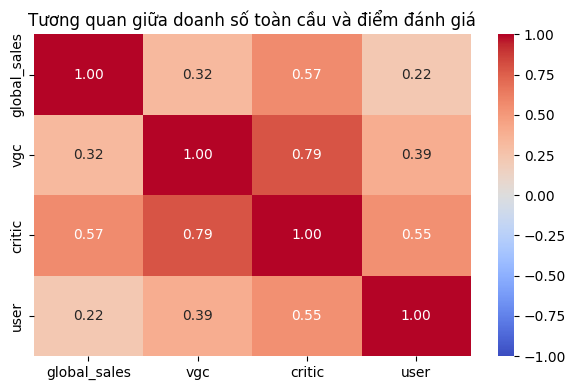

In [21]:
# Chỉ lấy những dòng có đủ thông tin điểm + doanh số
eda_global = df_trim[['global_sales'] + score_cols].dropna(how='any')

# Ma trận tương quan Pearson
corr = eda_global.corr(method='pearson')
print("Ma trận tương quan (Pearson):")
print(corr)

# Heatmap tương quan
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Tương quan giữa doanh số toàn cầu và điểm đánh giá")
plt.tight_layout()
plt.show()

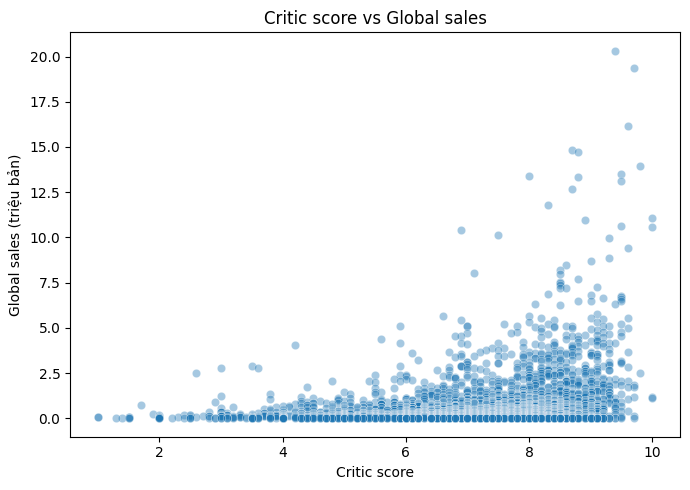

In [22]:
plt.figure(figsize=(7, 5))
sns.scatterplot(data=df_trim, x='critic', y='global_sales', alpha=0.4)
plt.title('Critic score vs Global sales')
plt.xlabel('Critic score')
plt.ylabel('Global sales (triệu bản)')
plt.tight_layout()
plt.show()

Nhận xét: Có thể thấy biểu đồ không hoàn toàn là tuyến tính, dữ liệu tập trung mạnh vào khoảng doanh số 0-2.5, tuy nhiên có thể thấy rằng nếu điểm đánh giá của giới phê bình thấp (khoảng 6 triệu bản trở xuống) thì sẽ không có sự đột phá về doanh số (khoảng 6 triệu bản trở lên), còn nếu điểm đánh giá từ giới phê bình từ khoảng 8-10 điểm thì vẫn sẽ có những game có doanh số kém nhưng sẽ có một số game có sự đột phá về doanh số (Khoảng 7.5 đến hơn 20 triệu bản).Tóm lại có thể thấy một phần nào có điểm đánh giá có ảnh hưởng đến doanh số nhưng không hoàn toàn tuyến tính, có thể có các yếu tố khác để 1 game bán chạy như marketing, danh tiếng nhà sản xuất,..

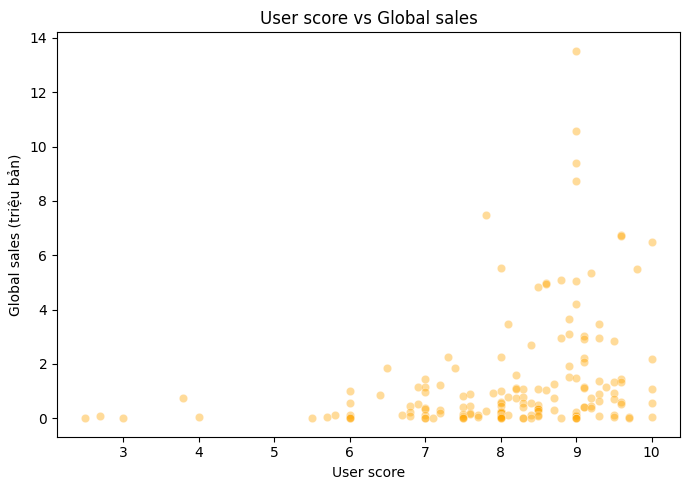

In [23]:
plt.figure(figsize=(7, 5))
sns.scatterplot(data=df_trim, x='user', y='global_sales', alpha=0.4, color='orange')
plt.title('User score vs Global sales')
plt.xlabel('User score')
plt.ylabel('Global sales (triệu bản)')
plt.tight_layout()
plt.show()

Nhận xét: Tương tự như Critic score nhưng dữ liệu đánh giá từ người chơi khá ít

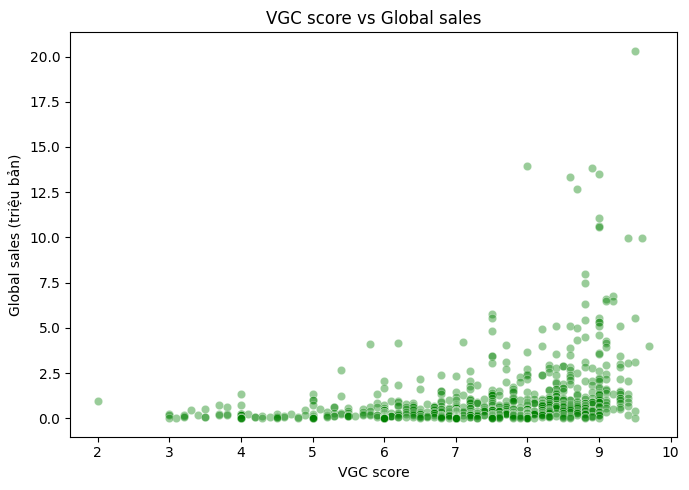

In [24]:
plt.figure(figsize=(7, 5))
sns.scatterplot(data=df_trim, x='vgc', y='global_sales', alpha=0.4, color='green')
plt.title('VGC score vs Global sales')
plt.xlabel('VGC score')
plt.ylabel('Global sales (triệu bản)')
plt.tight_layout()
plt.show()

Nhận xét: Tương tự như Crictic score nhưng dữ liệu cũng còn khá thưa

C:\Users\Administrator\AppData\Local\Temp\ipykernel_3152\2350016959.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = (df_scorebin.groupby('critic_bin')['global_sales']


  critic_bin  count      mean  median
0        <=5    419  0.267780    0.14
1        5-7   1374  0.432009    0.21
2        7-8   1176  0.605204    0.33
3        8-9    939  1.143376    0.58
4       9-10    190  2.521947    1.29


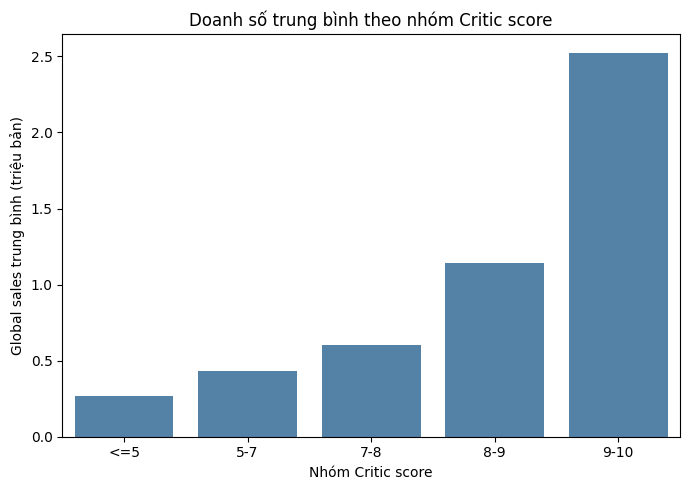

In [25]:
# Tạo bin cho critic score
bins = [0, 5, 7, 8, 9, 10]
labels = ['<=5', '5-7', '7-8', '8-9', '9-10']

df_scorebin = df_trim.copy()
df_scorebin = df_scorebin[df_scorebin['critic'].notna() & df_scorebin['global_sales'].notna()]
df_scorebin['critic_bin'] = pd.cut(df_scorebin['critic'], bins=bins, labels=labels, include_lowest=True)

grouped = (df_scorebin.groupby('critic_bin')['global_sales']
                     .agg(['count', 'mean', 'median'])
                     .reset_index())

print(grouped)

plt.figure(figsize=(7, 5))
sns.barplot(data=grouped, x='critic_bin', y='mean', color='steelblue')
plt.title('Doanh số trung bình theo nhóm Critic score')
plt.xlabel('Nhóm Critic score')
plt.ylabel('Global sales trung bình (triệu bản)')
plt.tight_layout()
plt.show()

Nhận xét: Có thể thấy doanh số trung bình giữa các nhóm điểm có một sự tuyến tính với doanh số khi điểm càng cao thì doanh số trung bình càng cao, đặc biệt là nhóm điểm 9-10 điểm thì doanh số trung bình tới gần 2.5 triệu bản gấp đôi so với nhóm 8-9 điểm

C:\Users\Administrator\AppData\Local\Temp\ipykernel_3152\2409032767.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_user = (df_userbin.groupby('user_bin')['global_sales']


  user_bin  count      mean  median
0      <=5      5  0.182000    0.05
1      5-7     25  0.470400    0.22
2      7-8     40  0.748500    0.23
3      8-9     52  2.079808    0.78
4     9-10     39  1.795897    1.10


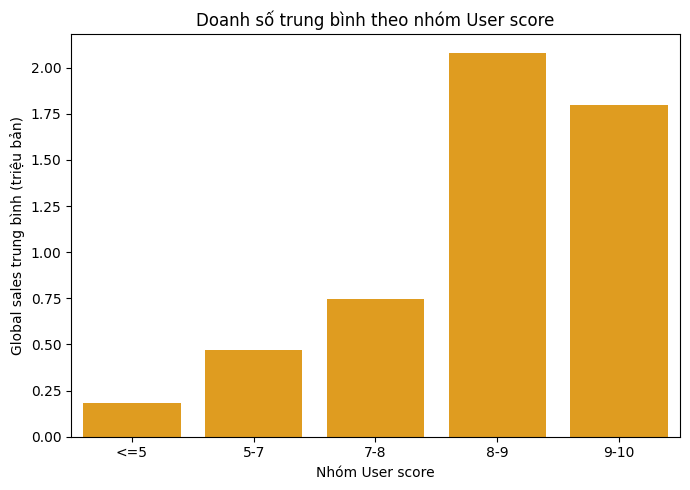

In [26]:
bins_user = [0, 5, 7, 8, 9, 10]
labels_user = ['<=5', '5-7', '7-8', '8-9', '9-10']

df_userbin = df_trim.copy()
df_userbin = df_userbin[df_userbin['user'].notna() & df_userbin['global_sales'].notna()]
df_userbin['user_bin'] = pd.cut(df_userbin['user'], bins=bins_user, labels=labels_user, include_lowest=True)

grouped_user = (df_userbin.groupby('user_bin')['global_sales']
                           .agg(['count', 'mean', 'median'])
                           .reset_index())

print(grouped_user)

plt.figure(figsize=(7, 5))
sns.barplot(data=grouped_user, x='user_bin', y='mean', color='orange')
plt.title('Doanh số trung bình theo nhóm User score')
plt.xlabel('Nhóm User score')
plt.ylabel('Global sales trung bình (triệu bản)')
plt.tight_layout()
plt.show()

Nhận xét: Khi nhóm điểm theo người chơi và tính doanh số trung bình từng khoảng thì đối với 4 nhóm đầu ta có thể thấy sự tuyến tính nhưng sau đó nhóm điểm 9-10 điểm thì doanh số lại thấp hơn so với 8-9 điểm, có thể ta nghi ngòw các yếu tố thiếu dữ liệu hoặc uy tín điểm đánh giá của người dùng

C:\Users\Administrator\AppData\Local\Temp\ipykernel_3152\3882478248.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_user = (df_vgcbin.groupby('vgc_bin')['global_sales']


  vgc_bin  count      mean  median
0     <=5      1  0.260000   0.260
1     5-7      5  0.434000   0.430
2     7-8     11  1.450909   0.740
3     8-9     22  3.086364   1.265
4    9-10     11  2.887273   2.830


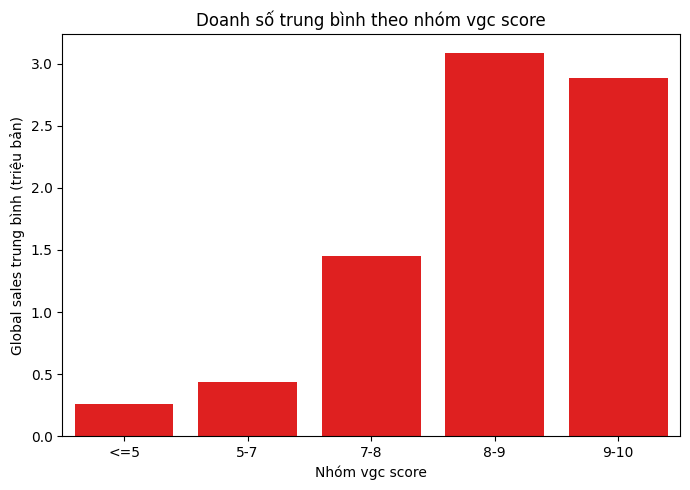

In [27]:
bins_vgc = [0, 5, 7, 8, 9, 10]
labels_vgc = ['<=5', '5-7', '7-8', '8-9', '9-10']

df_vgcbin = df_trim.copy()
df_vgcbin = df_vgcbin[df_vgcbin['user'].notna() & df_vgcbin['global_sales'].notna()]
df_vgcbin['vgc_bin'] = pd.cut(df_vgcbin['vgc'], bins=bins_vgc, labels=labels_vgc, include_lowest=True)

grouped_user = (df_vgcbin.groupby('vgc_bin')['global_sales']
                           .agg(['count', 'mean', 'median'])
                           .reset_index())

print(grouped_user)

plt.figure(figsize=(7, 5))
sns.barplot(data=grouped_user, x='vgc_bin', y='mean', color='red')
plt.title('Doanh số trung bình theo nhóm vgc score')
plt.xlabel('Nhóm vgc score')
plt.ylabel('Global sales trung bình (triệu bản)')
plt.tight_layout()
plt.show()

Nhận xét: Đối với doanh số trung bình của điểm đánh giá từ trang VGC cũng tương tự so với điểm đánh giá của người chơi

### Trả lời tổng hợp cho câu hỏi 5

Đối với biến Critic score scatter cho thấy ở cùng một mức điểm critic, doanh số có thể dao động từ gần 0 đến vài triệu bản → điểm đánh giá không phải là yếu tố duy nhất quyết định doanh số. Tuy nhiên, khi nhóm điểm thành các khoảng (≤5, 5–7, 7–8, 8–9, 9–10) và tính doanh số trung bình, ta thấy có một sự tuyến tính rõ rệt và nhóm 9–10 có doanh số trung bình toàn cầu cao nhất, vượt trội so với các nhóm thấp hơn.

Đối với User score và VGC score bằng chứng yếu, không rõ xu hướng tăng và dữ liệu của 2 nhóm này lại còn ít so với Critic score. 
Khi nhóm điểm thành các khoảng tương tự, doanh số trung bình không tăng rõ rệt theo điểm,nhóm 8–9 đôi khi còn có doanh số trung bình cao hơn nhóm 9–10.Với chất lượng dữ liệu hiện tại, chưa thể khẳng định game điểm user/VGC cao sẽ bán chạy hơn một cách nhất quán.



### Lời khuyên chiến lược

Đầu tư để đạt “ngưỡng chất lượng” thay vì chỉ tăng điểm chút ít
- Phân tích cho thấy chênh lệch mạnh nằm ở nhóm critic 9–10 so với phần còn lại.
- Nếu chi phí cho thiết kế game giúp game từ ~7–8 lên ~9–10 là hợp lý, đây có thể là khoản đầu tư có lợi về doanh số trung bình.
- Ngược lại, cố gắng kéo từ 6 → 7.5 nhưng vẫn không chạm 9 có thể không mang lại khác biệt doanh số rõ rệt.

Trong mô hình dự đoán doanh số
- Nên bao gồm critic như một feature chính và kết hợp với các thuộc tính khác đã biết nó ảnh hưởng đến doanh thu sau khi khám phá không nên xây mô hình chỉ dựa trên điểm đánh giá, vì như scatter đã cho thấy, nhiều game điểm gần giống nhau nhưng doanh số chênh lệch rất lớn.

Rủi ro và hạn chế
- Dữ liệu của user và vgc thiếu khá nhiều dẫn đến kết luận về hai cột này phải thận trọng.
- Kết quả phản ánh dataset hiện tại, không nhất thiết đại diện toàn bộ thị trường game.

## Câu hỏi 6: Phân tích sức ảnh hưởng của các yếu tố định danh (Identity Factors) lên doanh số toàn cầu: Liệu danh tiếng, năm phát hành, nền tảng có đủ để đảm bảo thành công thương mại?

### Motivation & Benefits
- Lý do nghiên cứu: Trong ngành công nghiệp game, các yếu tố như nhà phát triển hay nhà phát hành thường được coi là bảo chứng cho doanh số. Việc điều tra này giúp xác định thực sự các yếu tố định danh này quyết định bao nhiêu phần trăm thành công của một sản phẩm.
- Lợi ích và thông tin chi tiết: Cung cấp cái nhìn khách quan về việc liệu một tên tuổi lớn có mặc định tạo ra doanh thu cao hay không, hay các yếu tố khác như điểm phê bình mới là động lực chính, hay lại là những yếu tố khác ngoài dataset.
- Đối tượng quan tâm: Các nhà đầu tư chiến lược, bộ phận marketing của các hãng game và các nhà nghiên cứu thị trường.
- Quyết định thực tế: Hỗ trợ các nhà phát hành định giá dự án dựa trên tiềm năng thương mại thực tế và quản lý kỳ vọng doanh thu dựa trên các đặc trưng sẵn có trước khi ra mắt.

### Preprocessing
Quy trình xử lý dữ liệu được thực hiện theo các bước:
1. Kỹ thuật đặc trưng: Tạo biến độ tuổi game (age_of_game) và số lượng game đã làm của nhà phát triển (dev_experience).
2. Chia tách dữ liệu: Tách tập huấn luyện và kiểm tra theo tỷ lệ 80/20.
3. Mã hóa mục tiêu: Thay thế các biến phân loại (nhà phát triển, nhà phát hành, nền tảng) bằng trung bình doanh số tương ứng để giảm chiều dữ liệu.
4. Xử lý ngoại lai: Loại bỏ 2% game có doanh số cao nhất ở tập huấn luyện nhằm giảm nhiễu từ các siêu bom tấn.
5. Biến đổi logarithm: Áp dụng log1p cho doanh số để nén các giá trị cực lớn.

### Analysis
Phương pháp phân tích và đánh giá mô hình:
1. Mô hình lựa chọn: So sánh Linear Regression (mô hình cơ sở) và Random Forest (mô hình phi tuyến tính) để tìm ra thuật toán tối ưu.
2. Phương pháp đánh giá: Sử dụng kiểm chứng chéo (K=5) trên tập huấn luyện để đảm bảo tính ổn định. Kết quả dự đoán được chuyển ngược từ thang log về đơn vị triệu bản để đối chiếu thực tế.
3. Chỉ số đo lường: 
  - MAE: Đo độ lệch trung bình (triệu bản) giữa dự báo và thực tế.
  - R-squared: Đánh giá khả năng giải thích sự biến động doanh số của mô hình.
4. Kết quả kỳ vọng: Bảng so sánh hiệu năng giữa hai mô hình và biểu đồ tầm quan trọng của các đặc trưng để xác định yếu tố chi phối doanh thu.

Cài đặt các thư viện cần thiết và chuẩn bị cột year với loại bỏ những dòng thiếu total
- Ở đây chúng em sẽ dùng total làm target chứu không phải shipped vì: total và shipped cũng có ý nghĩa tương đương nhau nhưng shipped chỉ có khoảng 4000 dòng dữ liệu, còn ít hơn số giá trị unique của developer.

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
df_model = df.copy()
# 2. Đảm bảo cột Year đã đúng định dạng 
df_model['date'] = pd.to_datetime(df_model['date'], errors='coerce')
df_model['year'] = df_model['date'].dt.year

# Loại bỏ các dòng không có doanh số hoặc không có năm để model không bị nhiễu
df_model = df_model[df_model['total'] > 0]
df_model = df_model[df_model['year'].notna()]

target encoding với các cột developer, publisher, platform, 

BẢNG SO SÁNH HIỆU NĂNG MÔ HÌNH
            Model CV R2 (Log) Test MAE Test R2
Linear Regression       0.357    0.274   0.190
    Random Forest       0.499    0.252   0.244


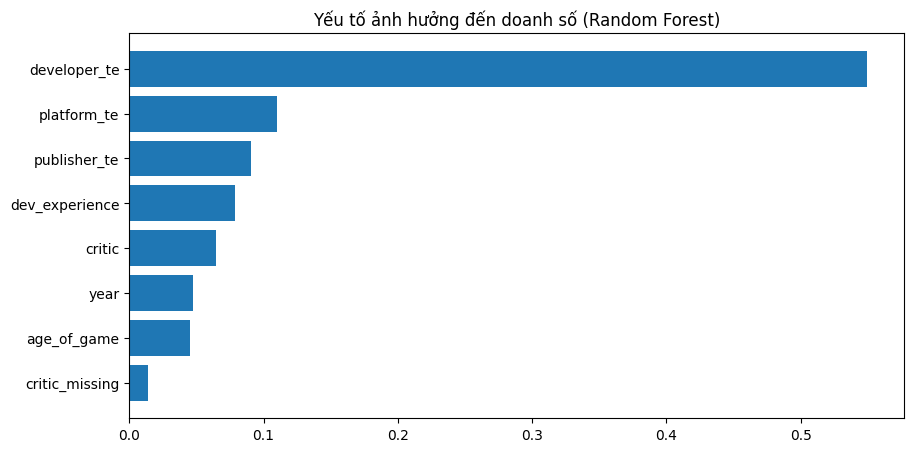

In [29]:


# --- 1. PREPARATION & FEATURE ENGINEERING ---
df_fe = df_model.copy()
df_fe['age_of_game'] = 2024 - df_fe['year']
df_fe['dev_experience'] = df_fe['developer'].map(df_fe['developer'].value_counts())

# --- 2. TRAIN / TEST SPLIT ---
df_train, df_test = train_test_split(df_fe, test_size=0.2, random_state=42)
df_train, df_test = df_train.copy(), df_test.copy()

df_train['critic_missing'] = df_train['critic'].isna().astype(int)
df_test['critic_missing'] = df_test['critic'].isna().astype(int)

# Tính Median của critic từ tập TRAIN
critic_median = df_train['critic'].median()

# Điền giá trị thiếu bằng Median học được từ tập Train
df_train['critic'] = df_train['critic'].fillna(critic_median)
df_test['critic'] = df_test['critic'].fillna(critic_median)

# --- 3. TARGET ENCODING (Học từ Train, Map sang Test) ---
target_cols = ['publisher', 'developer', 'platform']
for col in target_cols:
    map_values = df_train.groupby(col)['total'].mean()
    global_median = df_train['total'].median()
    
    df_train[f'{col}_te'] = df_train[col].map(map_values)
    df_test[f'{col}_te'] = df_test[col].map(map_values)
    
    df_train[f'{col}_te'] = df_train[f'{col}_te'].fillna(global_median)
    df_test[f'{col}_te'] = df_test[f'{col}_te'].fillna(global_median)


# --- 4. OUTLIER FILTERING chỉ lọc trên tập train để giữ tính thực tế cho test ---
upper_limit = df_train['total'].quantile(0.98)
df_train = df_train[df_train['total'] <= upper_limit].copy()

# --- 5. PREPARE x / y ---
features = ['year','critic', 'critic_missing', 'age_of_game', 'dev_experience', 'publisher_te', 'developer_te', 'platform_te']
X_train = df_train[features].fillna(0)
X_test = df_test[features].fillna(0)

# Log transform để nén phân phối doanh số
y_train_log = np.log1p(df_train['total'])
y_test_original = df_test['total'] # Giữ gốc để tính metric cuối cùng

# --- 6. MODELING & COMPARISON ---
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, min_samples_leaf=5, random_state=42, n_jobs=-1)
}

results = []

for name, model in models.items():
    # Cross-validation trên tập Train (dùng R2 score)
    cv_scores = cross_val_score(model, X_train, y_train_log, cv=5, scoring='r2')
    
    # Huấn luyện trên toàn bộ tập Train
    model.fit(X_train, y_train_log)
    
    # Dự đoán trên Test và chuyển ngược về đơn vị gốc (triệu bản)
    y_pred_log = model.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    
    # Tính toán Metric
    mae = mean_absolute_error(y_test_original, y_pred)
    r2 = r2_score(y_test_original, y_pred)
    
    results.append({
        "Model": name,
        "CV R2 (Log)": f"{cv_scores.mean():.3f}",
        "Test MAE": f"{mae:.3f}",
        "Test R2": f"{r2:.3f}"
    })

# --- 7. HIỂN THỊ KẾT QUẢ ---
results_df = pd.DataFrame(results)
print("BẢNG SO SÁNH HIỆU NĂNG MÔ HÌNH")
print(results_df.to_string(index=False))

# Trực quan hóa Feature Importance của model tốt nhất (Random Forest)
importances = models["Random Forest"].feature_importances_
sorted_idx = np.argsort(importances)
plt.figure(figsize=(10, 5))
plt.barh(np.array(features)[sorted_idx], importances[sorted_idx])
plt.title("Yếu tố ảnh hưởng đến doanh số (Random Forest)")
plt.show()

#### Nhận xét kết quả mô hình
Dựa trên bảng so sánh hiệu năng, chúng ta có các quan sát sau:
Sự vượt trội của Random Forest: Mô hình Random Forest đạt CV R2 (Log) là 0.499, cao hơn đáng kể so với Linear Regression (0.357). Điều này chứng tỏ mối quan hệ giữa các yếu tố định danh và doanh số mang tính phi tuyến tính phức tạp mà các mô hình truyền thống khó nắm bắt đầy đủ.

Độ lệch giữa các thang đo: Chỉ số Test R2 (0.244) thấp hơn so với thang đo log. Đây là hiện tượng phổ biến trong dữ liệu doanh số game (bị lệch nặng), khi các sai số nhỏ ở thang Log bị khuếch đại khi đưa về đơn vị triệu bản thực tế, đặc biệt là ở các nhóm game bán chạy nhất.

Độ chính xác thực tế: Với MAE là 0.252, trung bình mô hình chỉ dự báo lệch khoảng 252,000 bản so với thực tế.

### Trả lời cho câu 6
1. Danh tiếng là yếu tố quyết định: developer_te (danh tiếng nhà phát triển được mã hóa qua doanh số trung bình) chiếm tỷ trọng ảnh hưởng lớn nhất (hơn 50%). Điều này khẳng định danh tiếng của nhà sản xuất là bảo chứng mạnh mẽ nhất cho sự thành công thương mại.
2. Nền tảng và nhà phát hành: Đứng vị trí tiếp theo là platform_te và publisher_te. Việc lựa chọn hệ máy phát hành và đơn vị phân phối đóng vai trò quan trọng trong việc tiếp cận tệp khách hàng tiềm năng.
3.Kết luận về tính đủ của dữ liệu: Mặc dù mô hình đã nắm bắt được quy luật chung, nhưng chỉ số R-squared ~ 0.244 cho thấy danh tiếng và nền tảng chỉ giải thích được khoảng 24.4% sự biến động của doanh số.
4. Yếu tố ngoài hệ thống: Phần lớn sự thành công (hơn 75%) còn lại phụ thuộc vào các yếu tố nằm ngoài bộ dữ liệu định danh như chất lượng gameplay thực tế, các chiến dịch marketing, sức hút từ cộng đồng (viral) và thời điểm ra mắt so với các đối thủ cạnh tranh.
5. Kết luận cuối cùng: Danh tiếng và nền tảng là điều kiện "cần" nhưng chưa "đủ" để đảm bảo một trò chơi sẽ chắc chắn thành công rực rỡ.


# 4. Project summary

## 4.1 Key findings
1. Phân tích cho thấy chênh lệch doanh số mạnh nằm ở nhóm critic 9–10 so với phần còn lại.
- Nếu chi phí cho thiết kế game giúp game từ ~7–8 lên ~9–10 là hợp lý, đây có thể là khoản đầu tư có lợi về doanh số trung bình.
- Ngược lại, cố gắng kéo từ 6 → 7.5 nhưng vẫn không chạm 9 có thể không mang lại khác biệt doanh số rõ rệt.

2. Thị trường nền tảng cho video game đang thu hẹp, ghi nhận gần nhất chỉ có 6 platform đang phổ biến.
- Có 2 platform có vẻ tiềm năng: PS5 và XS. 
- PS5 được marketing khá mạnh nên có vẻ được giới trẻ biết đến rất nhiều, doanh số cũng có xu hướng tăng.
- Nhà phát hành và phát triển muốn chạy theo xu thế nên làm game trên hai platform này.
3. Platform ưa thích (dựa theo doanh số) của mỗi khu vực là khác nhau:
- America: GEN
- Europe: GBC
- Japan: NES 
- Other: PS4
Nếu bạn là nhà phát hành/phát triển mới, nên lựa chọn platform ưa thích của từng khu vực.
4. Thị trường video game bùng nổ nhất vào năm 2010-2011, lúc đó doanh số toàn cầu ghi nhận là hơn 200 triệu bản, sau giai đoạn đó giảm mạnh đến 2020. 
- Sau 2020 không có data nên không khẳng định được, nhưng có thể đoán được thị trường video game giảm mạnh đến vậy do sự phát triển của điện thoại, laptop, dần dần video game sẽ tốn kém hơn nhiều so với các game trên app hay trên web. Tuy nhiên video game vẫn luôn có chỗ đứng trong giới game thủ.
5. Danh tiếng nhà phát hành và nhà phát triển hay platform của game hay năm phát triển chỉ giải thích được 25% cho doanh số bán ra, trong đó danh tiếng của nhà phát triển chiếm vị trí quan trọng nhất 75% còn lại có thể thuộc về những phần không có trong dataset này như thể loại game, kinh phí marketing, ...

## 4.2 Limitations
-	Do sau năm 2018 VGChart ngừng ước tính doanh số phần mềm nên dữ liệu chủ yếu phản ánh doanh số bán lẻ vật lý, nên có thể dữ liệu về doanh số phần mềm sẽ bị thiếu hoặc ít và phần lớn dữ liệu doanh số cũng chỉ là ước tính từ VGChart chỉ một số ít là từ nhà phát hành nên cũng có thể có rủi ro về ước tính.Ngoài ra sự thiếu hụt về doanh số ở các vùng cụ thể và các điểm đánh giá cũng rất lớn, đây cũng là sự hạn chế về mặt dữ liệu.
Các hạn chế về phân tích.
-	Vì sự hạn chế ở mặt dữ liệu bên trên đã đề cập nên khi phân tích các vấn đề, các câu hỏi dẫn đến sau khi đã lọc hết các giá trị thiếu thì cũng còn lại khá ít hoặc không có đủ thông tin mong muốn nên một phần nào các câu hỏi tưởng chừng có thể trả lời bằng dữ liệu nhưng thực tế lại không
Các hạn chế về phạm vi.
-	Vì các cột trong tập dữ liệu này chỉ bao gồm 14 cột, tuy không quá ít nhưng lại chưa thực sự có các cột chi tiết liên quan đến game như thể loại game,… để có thể hướng đến phân tích thêm về hành vi người dùng ở từng khu vực và game cụ thể,.. Ngoài ra về phần xây dựng mô hình, cũng hạn chế khi ít các cột dạng số tuyến tính với doanh số như chi phí marketing,.. mà chỉ là các giá trị chung chung đối với một tựa game như nền tàng, nhà phát hành, nhà phát triển,…

## 4.3 Future Directions
1. Khám phá các câu hỏi nghiên cứu mới
Thay vì chỉ dự báo doanh số tổng thể (total), chúng em muốn đi sâu vào sự khác biệt giữa các thị trường:
- Vòng đời của hệ máy: Doanh số game thay đổi như thế nào vào giai đoạn đầu so với giai đoạn cuối của một vòng đời console (ví dụ: PS4 vs PS5)?
- 
2. Phân tích sâu hơn
Phân tích sai số: Nghiên cứu kỹ những trường hợp mô hình dự báo sai lệch lớn nhất (ví dụ: dự báo thấp nhưng doanh số thực tế cực cao) để tìm ra các biến số ẩn mà mô hình đang bỏ lỡ.
3. Phương pháp và tiếp cận thay thế
Mô hình Boosting: Thử nghiệm các thuật toán mạnh mẽ hơn như XGBoost, LightGBM hoặc CatBoost. Các mô hình này thường có hiệu suất tốt hơn Random Forest trong việc xử lý dữ liệu bảng hiệu quả hơn.
4. Tìm kiếm dữ liệu bổ sung (Additional Data)
- Dữ liệu hiện tại chủ yếu là thông tin định danh, chúng em muốn bổ sung thêm:
- Dữ liệu Marketing: Ngân sách quảng cáo và độ phủ truyền thông của từng tựa game.
- Điểm số đánh giá: Điểm từ giới phê bình và đánh giá từ người dùng, vì đây là yếu tố then chốt ảnh hưởng đến quyết định mua hàng nhưng hiện tại thì trong tập dataset thì những dữ liệu về critic hay user khá ít để có thể train.
- Tạo cột Genre bằng cách cào hoặc tự phân loại.
5. Mở rộng và cải thiện quy trình 
Xây dựng mô hình có thể đưa ra lời khuyên, và phương pháp để tăng doanh thu cho game tùy vào khu vực, hay xu hướng sở thích của người chơi tại thời điểm đó bằng cách đưa ra các chiến lược marketing phù hợp cho từng khu vực, đầu tư vào platform nào cho khu vực nào, nên áp dụng ưu đãi ra sao.

## 4.4 Individual Reflection

### A. 23127083 - Phạm Khánh Linh
1. Challenges & difficulties encountered
- Trong phần phân tích mối tương quan giữa các thuộc tính, khó khai thác được hết data qua bảng chéo categoric x categoric hay numeric x categoric vì giá trị unique trên các cột categoric quá nhiều, tạo bảng không hiệu quả.
- Em chỉ tạo bảng với top 10 giá trị xuất hiện nhiều nhất của mỗi cột categoric và có két quả phân tích tạm ổn.
- Phần thử thách nhất là tìm mối tương quan xem 
2. Learning and growth
- Về kỹ năng: học thêm được target encoding, rất có ích cho những cột quá nhiều giá trị unique
- Về domain: hiểu được thị trường video game, có những phát hiện bất ngờ với người chưa từng chơi video game: PC là nền tảng trường tồn, iOS cũng có làm video game, ở Nhật thì Nintendo thống trị thị trường. <br>
Project này giúp em phát triển kỹ năng 
- Phân tích dữ liệu có nhiều bất lợi: thiếu nhiều trường dữ liệu, dữ liệu đa phần unique. 
- Tiền xử lý dữ liệu cho phù hợp với model.

### B. 23127190 - Võ Trung Hiếu
1. Challenges & difficulties encountered
- Trong quá trình thực hiện dự án, em gặp khá nhiều khó khăn cả về mặt kỹ thuật lẫn tư duy phân tích dữ liệu. Có thể kể đến như là xử lý dữ liệu có nhiều biến phân loại với số lượng giá trị rất lớn như publisher và developer.
- Ban đầu, em nhận thấy việc áp dụng One-Hot Encoding (OHE) gây ra khó khăn lớn cho mô hình Random Forest Regression. OHE tạo ra hàng ngàn cột mới chứa toàn số 0 và 1 (ma trận thưa), khiến các cây quyết định trong Random Forest bị loãng thông tin. Khi mỗi nhánh cây phải chọn ngẫu nhiên một vài đặc trưng để chia (max_features), xác suất chọn trúng những cột quan trọng bị giảm mạnh, làm mô hình mất khả năng bắt được quy luật. Để khắc phục, em đã chuyển sang sử dụng Target Encoding. Thay vì tạo thêm cột, phương pháp này thay thế các nhãn chữ bằng giá trị trung bình của biến mục tiêu total tương ứng với nhãn đó. Điều này giúp giữ nguyên số lượng cột, giảm độ phức tạp tính toán mà vẫn truyền tải được mối quan hệ về doanh số vào mô hình.
2. Learning and growth
Thông qua dự án này, em có thêm kiến thức về các kỹ thuật xử lý dữ liệu và biết thêm về thuật toán Random Forest, bên cạnh đó còn là tầm quan trọng của việc tránh data leakage trong quá trình encoding và đánh giá mô hình. Em cũng hiểu rõ hơn sự khác biệt giữa các thuật toán như Linear Regression và Random Forest, cũng như lý do vì sao các phương pháp encoding khác nhau lại phù hợp với từng loại mô hình. Điều khiến em bất ngờ là việc chỉ cần thay đổi cách xử lý biến phân loại cũng có thể tạo ra sự khác biệt đáng kể trong kết quả dự đoán. Dự án đã giúp em hình thành tư duy làm data science một cách hệ thống hơn.


### C. 2327493 - Võ Hoàng Thương
1. Challenges and difficulties encountered
-	Về mặt kĩ thuật và khái niệm cũng sẽ có những kĩ thuật và khái niệm mới em chưa từng gặp nhưng đây cũng không phải là một khó khăn lớn vì đã có nhiều công cụ như chatGPT,gemini,… để truy vấn nên cũng dễ dàng giải quyết
-	Về mặt phân tích thì đây cũng là một sự thách thức lớn khi mà em chưa thực sự có nhiều kinh nghiệm về mặt phân tích dữ liệu, dẫn đến có thể ở phần đặt câu hỏi có thể chưa thật sự là một câu hỏi tốt hoặc là hướng phân tích cho câu hỏi đó chưa phải là tối ưu và cũng có thể thiếu một số bước “ẩn” làm cho insight tìm ra chưa đủ ý nghĩa
-	Khó khăn lớn nhất đó là về sự thiếu hụt dữ liệu liên quan đến tổng doanh thu hoặc doanh thu các vùng, đây là một thách thức lớn nhất đối với em trong đồ án vì thiếu như vậy dẫn đến sau khi lọc ra thì còn lại một số nhỏ dữ liệu và nên dẫn đến insight khi kết luận nó sẽ có thể đúng trên tập nhỏ này 
2. Learning and growth
-	Ngoài học trên lớp thì đồ án cũng giúp em thực hành và học thêm khá nhiều với các thư viện phục vụ cho khoa học dữ liệu, hơn thế cũng học được cách code để phân tích trả lời một câu hỏi vì EDA để trả lời một câu hỏi chưa được dạy trên lớp nhiều, ngoài ra cũng được bổ sung một số kiến thức học máy như one hot encoding, RandomForest,…
-	Qua đồ án này em cũng hiểu hơn về một quy trình dữ liệu là các bước có thể lặp đi lặp lại một cách linh hoạt, không phải chỉ đơn giản là một quy trình tuyến tính, ngoài ra thì cũng hiểu được vai trò của một nhà khoa học dữ liệu là gì sau khi tìm ra được các insight từ dữ liệu.
